This solution is used to provide a anxuliary comparison to see what would happen if we only use 250 sources as the defining sources in the VLBI data reduction. 

Two solutions are included in the comparison.

One is the `opa2019a`, which is a standrad global VLBI solution within the frame of ICRF3.

The other use the same configuration as the `opa2019a` but uses only 250 sources among the ICRF3 defining source list to maintain the celestial frame.

In [1]:
from astropy.table import Table, Column
from astropy.time import Time
import astropy.units as u
import bottleneck as bn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from my_progs.vlbi.read_sou import read_sou
from my_progs.catalog.pos_diff import radio_cat_diff_calc

sou1 = read_sou("../data/opa2019a/opa2019a.sou")
sou2 = read_sou("../data/opa2019a-250/opa2019a-250.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(sou2, sou1, sou_name="iers_name")

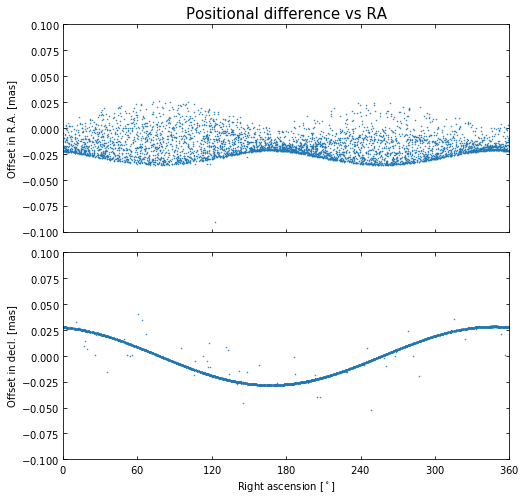

In [3]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(souoft["ra"], souoft["dra"], ".", ms=1)
ax1.plot(souoft["ra"], souoft["ddec"], ".", ms=1)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right ascension [$^\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-0.1, 0.1])
ax1.set_ylim([-0.1, 0.1])

ax0.set_title("Positional difference vs RA", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

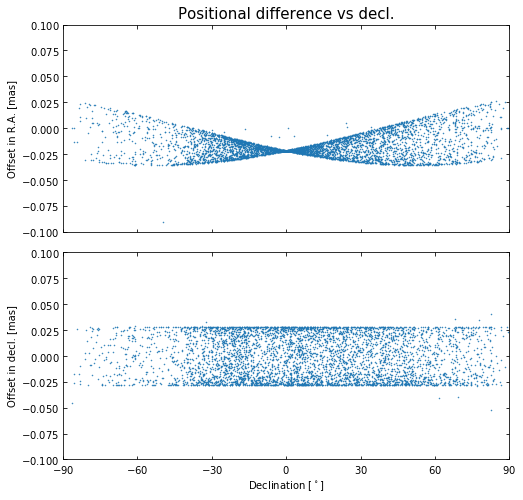

In [4]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(souoft["dec"], souoft["dra"], ".", ms=1)
ax1.plot(souoft["dec"], souoft["ddec"], ".", ms=1)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$^\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-0.1, 0.1])
ax1.set_ylim([-0.1, 0.1])

ax0.set_title("Positional difference vs decl.", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

The comparison of radio source positions shows only a difference in the axial orientation of ~$30\,\mu as$.

No deformation term can be found.

In [5]:
# My modules
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting

# gcrf250 - opa2019a
# Transform columns into np.array
dra1 = np.array(souoft["dra"])
ddec1 = np.array(souoft["ddec"])
dra_err1 = np.array(souoft["dra_err"])
ddec_err1 = np.array(souoft["ddec_err"])
ra_rad1 = np.array(souoft["ra"].to(u.radian))
dec_rad1 = np.array(souoft["dec"].to(u.radian))
dra_ddec_cov1 = np.array(souoft["dra_ddec_cov"])

# Transformation parameters
# l_max = 2
par1, sig1, _, _, _, _ = vsh_deg02_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1,
#     cov=dra_ddec_cov1, elim_flag="None")
         elim_flag="None")

# mas -> uas
par1 = par1 * 1.e3
sig1 = sig1 * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "             x             y             z"
      "             x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra1.size,
       par1[3], sig1[3], par1[4], sig1[4], par1[5], sig1[5],
       par1[0], sig1[0], par1[1], sig1[1], par1[2], sig1[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])

print("Positional difference")
t_quad1 = Table([quad_names, par1[6:], sig1[6:]],
                names=["Quadrupolar term", "Estimate", "Error"])
t_quad1["Estimate"].format = "%5.0f"
t_quad1["Error"].format = "%5.0f"
print(t_quad1)

print(dra1.size,
      " %+4.0f %3.0f  %+4.0f %3.0f  %+4.0f %3.0f"
      " %+4.0f %3.0f  %+4.0f %3.0f  %+4.0f %3.0f" % 
      (par1[3], sig1[3], par1[4], sig1[4], par1[5], sig1[5],
       par1[0], sig1[0], par1[1], sig1[1], par1[2], sig1[2]))

Estimates (  4600 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
             x             y             z             x             y             z
--------------------------------------------------------------------------------------------
          -6 +/-   0   -28 +/-   0   -22 +/-   0          -0 +/-   0    +0 +/-   0    +0 +/-   0
--------------------------------------------------------------------------------------------

Positional difference
Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -0     0
            EI22        0     0
            ER21       -0     0
            EI21       -0     0
             E20       -0     0
            MR22        0     0
            MI22       -0     0
            MR21        0     0
            MI21        0     0
             M20        0     0
4600    -6  

In [6]:
from my_progs.vlbi.read_eop import read_eob
from my_progs.vlbi.comp_eop import calc_eop_offset

eob1 = read_eob("../data/opa2019a/opa2019a.eob")
eob2 = read_eob("../data/opa2019a-250/opa2019a-250.eob")

eoboft = calc_eop_offset(eob1, eob2, "../logs/test_eob_offset.dat")

# Create a Time object for epochs of EOP
eoboft.sort("epoch_pmr")

# which is convenient to convert unit from mjd to jyear
pmrEpoch = Time(eoboft["epoch_pmr"], format="mjd")

nutEpoch = Time(eoboft["epoch_nut"], format="mjd")

There are 6633 and 6633 points in series 1 and series 2, respectively,between which 6633 are common.
Save the EOP offset series in ../logs/test_eob_offset.dat


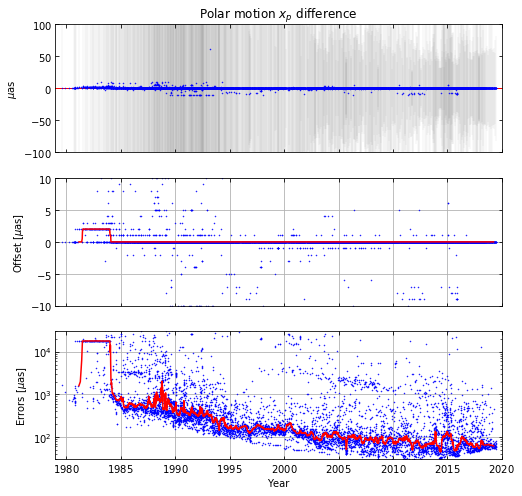

In [13]:
# Polar motion xp
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (8, 8), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(pmrEpoch.jyear,
            eoboft["dxp"],
            yerr = eoboft["dxp_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.05,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(pmrEpoch.jyear, eoboft["dxp"], "b.", ms = 1)
epomed = bn.move_median(pmrEpoch.jyear, window=50)
dxpmed = bn.move_median(eoboft["dxp"], window=50)
ax1.plot(epomed, dxpmed, "r")


# Formal error
ax2.plot(pmrEpoch.jyear, eoboft["dxp_err"], "b.", ms = 1)
dxperrmed = bn.move_median(eoboft["dxp_err"], window=50)
ax2.plot(epomed, dxperrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)
# ax1.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -100, 100])
ax1.set_ylim([-10, 10])
ax2.set_ylim([30, 30000])

# Titles and Labels
ax0.set_title("Polar motion $x_p$ difference")
ax0.set_ylabel("$\mu$as")
ax1.set_ylabel("Offset [$\mu$as]")
ax2.set_ylabel("Errors [$\mu$as]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(5))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

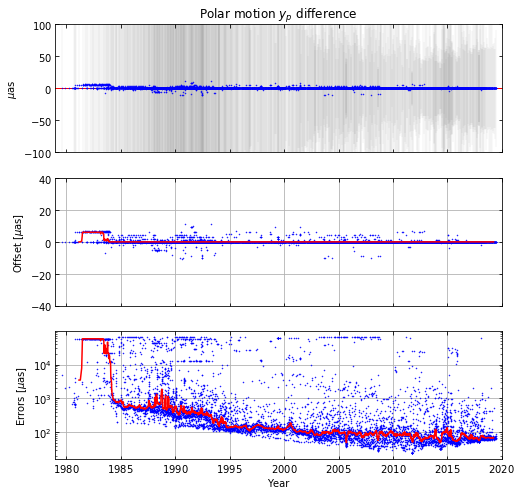

In [14]:
# Polar motion yp
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (8, 8), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(pmrEpoch.jyear,
            eoboft["dyp"],
            yerr = eoboft["dyp_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.05,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(pmrEpoch.jyear, eoboft["dyp"], "b.", ms = 1)
epomed = bn.move_median(pmrEpoch.jyear, window=50)
dypmed = bn.move_median(eoboft["dyp"], window=50)
ax1.plot(epomed, dypmed, "r")


# Formal error
ax2.plot(pmrEpoch.jyear, eoboft["dyp_err"], "b.", ms = 1)
dyperrmed = bn.move_median(eoboft["dyp_err"], window=50)
ax2.plot(epomed, dyperrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -100, 100])
ax1.set_ylim([-40, 40])
# ax2.set_ylim([30, 40000])

# Titles and Labels
ax0.set_title("Polar motion $y_p$ difference")
ax0.set_ylabel("$\mu$as")
ax1.set_ylabel("Offset [$\mu$as]")
ax2.set_ylabel("Errors [$\mu$as]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(5))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

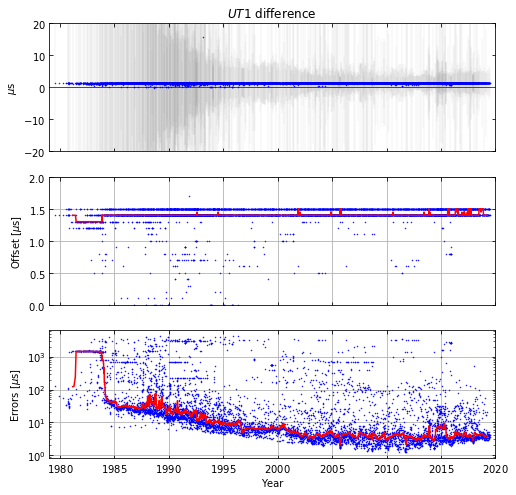

In [15]:
# UT1
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (8, 8), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(pmrEpoch.jyear,
            eoboft["dut"],
            yerr = eoboft["dut_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.05,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(pmrEpoch.jyear, eoboft["dut"], "b.", ms = 1)
epomed = bn.move_median(pmrEpoch.jyear, window=50)
dutmed = bn.move_median(eoboft["dut"], window=50)
ax1.plot(epomed, dutmed, "r")


# Formal error
ax2.plot(pmrEpoch.jyear, eoboft["dut_err"], "b.", ms = 1)
duterrmed = bn.move_median(eoboft["dut_err"], window=50)
ax2.plot(epomed, duterrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -20, 20])
ax1.set_ylim([0, 2])
# ax2.set_ylim([30, 40000])

# Titles and Labels
ax0.set_title("$UT1$ difference")
ax0.set_ylabel("$\mu$s")
ax1.set_ylabel("Offset [$\mu$s]")
ax2.set_ylabel("Errors [$\mu$s]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(0.5))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

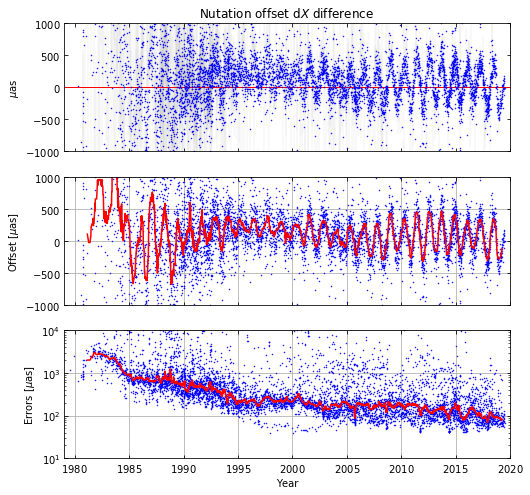

In [16]:
# Nutation offset dX
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (8, 8), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(nutEpoch.jyear,
            eoboft["ddX"],
            yerr = eoboft["ddX_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.05,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(nutEpoch.jyear, eoboft["ddX"], "b.", ms = 1)
epomed = bn.move_median(nutEpoch.jyear, window=50)
dutmed = bn.move_median(eoboft["ddX"], window=50)
ax1.plot(epomed, dutmed, "r")


# Formal error
ax2.plot(nutEpoch.jyear, eoboft["ddX_err"], "b.", ms = 1)
duterrmed = bn.move_median(eoboft["ddX_err"], window=50)
ax2.plot(epomed, duterrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -1000, 1000])
ax1.set_ylim([-1000, 1000])
ax2.set_ylim([10, 10000])

# Titles and Labels
ax0.set_title("Nutation offset d$X$ difference")
ax0.set_ylabel("$\mu$as")
ax1.set_ylabel("Offset [$\mu$as]")
ax2.set_ylabel("Errors [$\mu$as]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(10))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

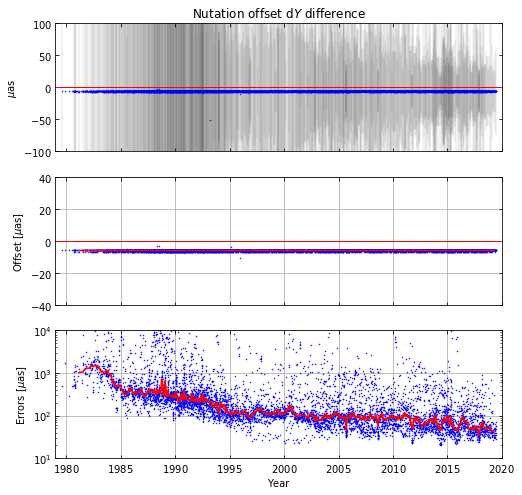

In [17]:
# Nutation offset dY
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (8, 8), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(nutEpoch.jyear,
            eoboft["ddY"],
            yerr = eoboft["ddY_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.1,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(nutEpoch.jyear, eoboft["ddY"], "b.", ms = 1)
epomed = bn.move_median(nutEpoch.jyear, window=50)
dutmed = bn.move_median(eoboft["ddY"], window=50)
ax1.plot(epomed, dutmed, "r")


# Formal error
ax2.plot(nutEpoch.jyear, eoboft["ddY_err"], "b.", ms = 1)
duterrmed = bn.move_median(eoboft["ddY_err"], window=50)
ax2.plot(epomed, duterrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)
ax1.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -100, 100])
ax1.set_ylim([-40, 40])
ax2.set_ylim([10, 10000])

# Titles and Labels
ax0.set_title("Nutation offset d$Y$ difference")
ax0.set_ylabel("$\mu$as")
ax1.set_ylabel("Offset [$\mu$as]")
ax2.set_ylabel("Errors [$\mu$as]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(10))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

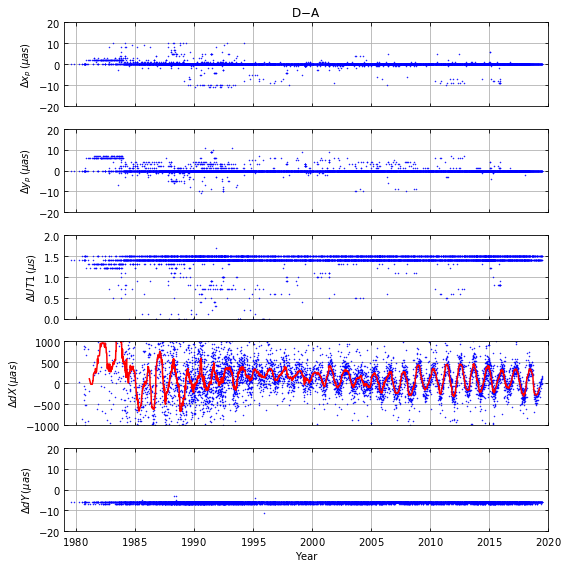

In [29]:
# EOP difference
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(8, 8), sharex=True, nrows=5)

# Error bar plot
ax0.plot(pmrEpoch.jyear, eoboft["dxp"], "b.", ms = 1)

ax1.plot(pmrEpoch.jyear, eoboft["dyp"], "b.", ms = 1)

ax2.plot(pmrEpoch.jyear, eoboft["dut"], "b.", ms = 1)

ax3.plot(nutEpoch.jyear, eoboft["ddX"], "b.", ms = 1)
epomed = bn.move_median(nutEpoch.jyear, window=50)
dutmed = bn.move_median(eoboft["ddX"], window=50)
ax3.plot(epomed, dutmed, "r")

ax4.plot(nutEpoch.jyear, eoboft["ddY"], "b.", ms = 1)

# Limits
ax0.axis([1979, 2020, -20, 20])
ax1.set_ylim([-20, 20])
ax2.set_ylim([0, 2])
ax3.set_ylim([-1000, 1000])
ax4.set_ylim([-20, 20])

# Titles and Labels
ax0.set_title("D$-$A")
ax0.set_ylabel("$\Delta x_p\,(\mu as)$")
ax1.set_ylabel("$\Delta y_p\,(\mu as)$")
ax2.set_ylabel("$\Delta UT1\,(\mu s)$")
ax3.set_ylabel("$\Delta dX\,(\mu as)$")
ax4.set_ylabel("$\Delta dY\,(\mu as)$")
ax4.set_xlabel("Year")

# Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

ax3.xaxis.set_ticks_position("both")
ax3.yaxis.set_ticks_position("both")

ax4.xaxis.set_ticks_position("both")
ax4.yaxis.set_ticks_position("both")

# grid
ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

plt.tight_layout()

plt.savefig("../plots/opa2019a-250-eop-diff.eps")